패키지 참조 -> 데이터 셋 준비 -> 데이터 전처리 -> 탐색적 데이터 분석 -> 데이터 셋 분할 -> 모델 개발 -> 학습 결과 평가 -> 학습 결과 적용

![res/code.png](res/code.png)

분석 프로세스를 진행한 이유와 해당 프로세서를 통해 얻은 결론을 설명
- 모든 단계는 목적과 근거를 제시

>머신러닝 - 소숫점 처리에 뛰어남

# 다중선형회귀

>다중회귀, 다항회귀는 다름

## #01. 패키지

In [1]:
import sys
sys.path.append("../../")
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## #02. 데이터 준비

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

## #04. 탐색적 데이터 분석

### 기초통계 확인

In [4]:
origin.describe()

,길이,높이,두께,무게
count,56.000000,56.000000,56.000000,56.000000
mean,27.892857,7.862143,4.745536,382.239286
std,9.021668,2.878343,1.775006,347.617717
min,8.400000,2.110000,1.410000,5.900000
25%,21.825000,5.690000,3.520000,120.000000
50%,25.300000,6.920000,4.155000,207.500000
75%,36.625000,10.850000,6.450000,692.500000
max,44.000000,12.800000,8.140000,1100.000000


> 평균값의 차이가 크기 때문에 표준화가 필요하다고 판단.

### boxplot

In [5]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["axes.unicode_minus"] = False

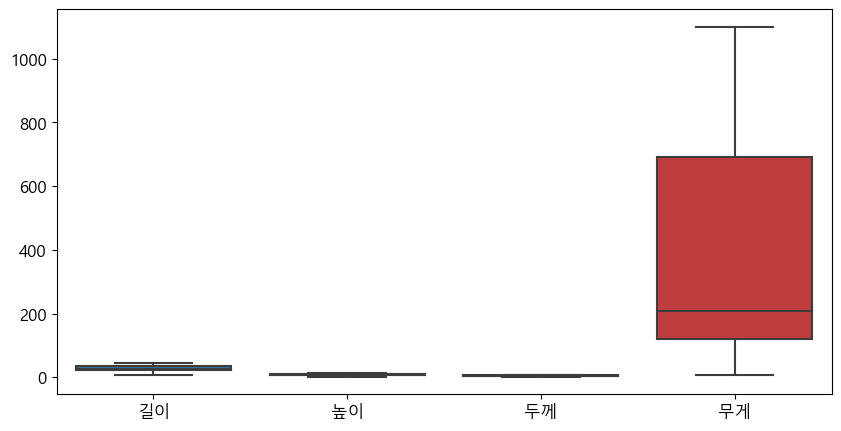

In [6]:
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> 데이터의 분포가 상이하므로 표준화가 필요하다고 판단.

### 산점도 그래프와 추세선 확인

이상 징후를 식별

한 변수가 다른 변수에 어떤 영향을 미치는지 확인

상관 관계, 패턴, 추세 또는 관계 보기

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

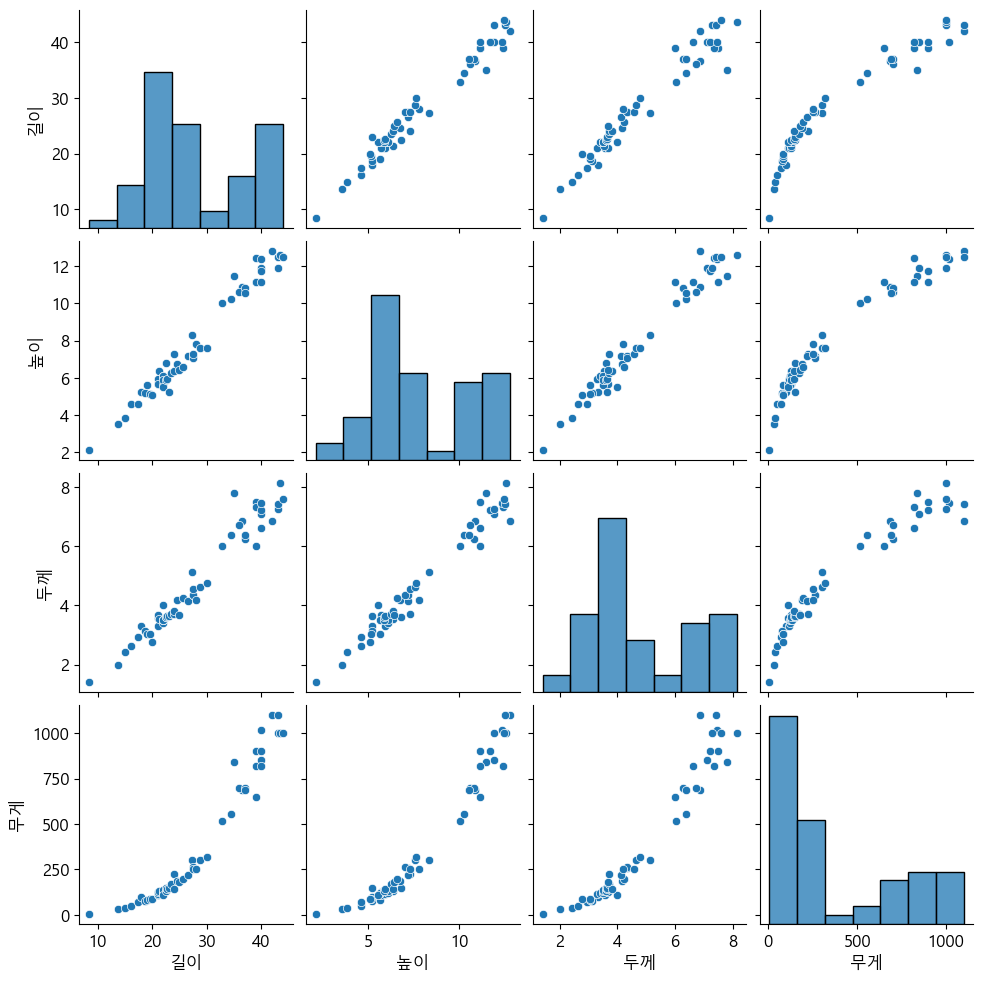

In [7]:
plt.figure(figsize=(15,15))
sb.pairplot(origin)
plt.show()
plt.close()

>다중공선성이 발생할 것으로 보이고, 선형회귀보다는 다항회귀가 더 적합해 보이지만 예제를 위해 다중선형회귀로 진행

## #05. 데이터 분할

### 랜덤시드 고정

In [8]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
type(origin)    #DF는 2차원

pandas.core.frame.DataFrame

In [10]:
origin.columns

Index(['길이', '높이', '두께', '무게'], dtype='object')

In [11]:
x = origin[['길이', '높이', '두께']]
y = origin[['무게']]
# (행 수, 열 수)
x.shape, y.shape

((56, 3), (56, 1))

### 데이터 표준화(정규화-scaling)

표준화는 2차원

차후 학습 결과 적용에서 스케일링 데이터를 사용해야하기 때문에 독립/종속 변수를 따로 스케일링

In [12]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((56, 3), (56, 1))

### 표준화 전 후 상자그림 비교

In [13]:
origin.columns

Index(['길이', '높이', '두께', '무게'], dtype='object')

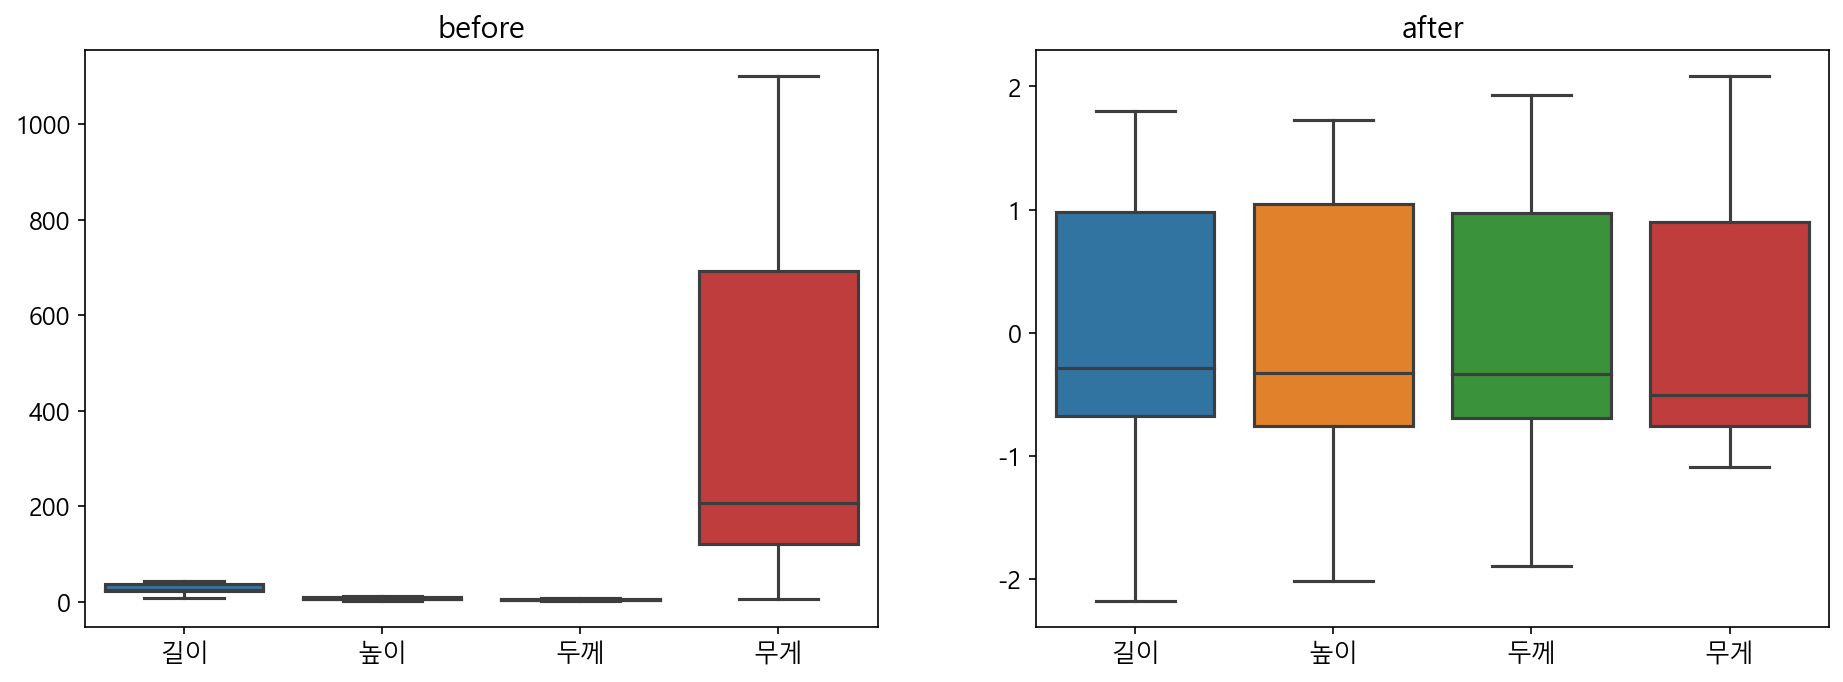

In [14]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합 - boxplot 확인용
x_scale_df = DataFrame(x_scale, columns=['길이', '높이', '두께'])
y_scale_df = DataFrame(y_scale, columns=['무게'])
tmp = merge(x_scale_df, y_scale_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=tmp, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 데이터, 검증 데이터 분할

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

- input_shape은 독립변수 수
- Dense(출력 수) 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [16]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)


Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [17]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
2/2 [==============================] - 1s 278ms/step - loss: 0.9480 - mae: 0.7172 - val_loss: 0.6207 - val_mae: 0.5624 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 74ms/step - loss: 0.8523 - mae: 0.6649 - val_loss: 0.5515 - val_mae: 0.5110 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 72ms/step - loss: 0.7668 - mae: 0.6232 - val_loss: 0.4877 - val_mae: 0.4633 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 75ms/step - loss: 0.6973 - mae: 0.5874 - val_loss: 0.4327 - val_mae: 0.4320 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 81ms/step - loss: 0.6354 - mae: 0.5555 - val_loss: 0.3876 - val_mae: 0.4110 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 44ms/step - loss: 0.5746 - mae: 0.5309 - val_loss: 0.3488 - val_mae: 0.3915 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5259 - mae: 0.5093 - val_loss: 0.3142 - val_mae: 0.3739 - lr: 0.001

## #07. 학습 결과 평가

### 데이터프레임화

In [18]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.947957,0.717169,0.620711,0.562352,0.001
2,0.852277,0.664881,0.551526,0.511046,0.001
3,0.766789,0.623216,0.487727,0.463345,0.001
4,0.697332,0.587401,0.432710,0.431960,0.001
5,0.635383,0.555546,0.387646,0.411008,0.001
...,...,...,...,...,...
61,0.022183,0.106182,0.018888,0.086692,0.001
62,0.022349,0.105971,0.019473,0.087679,0.001
63,0.022170,0.104867,0.019306,0.087030,0.001


### 손실률 시각화

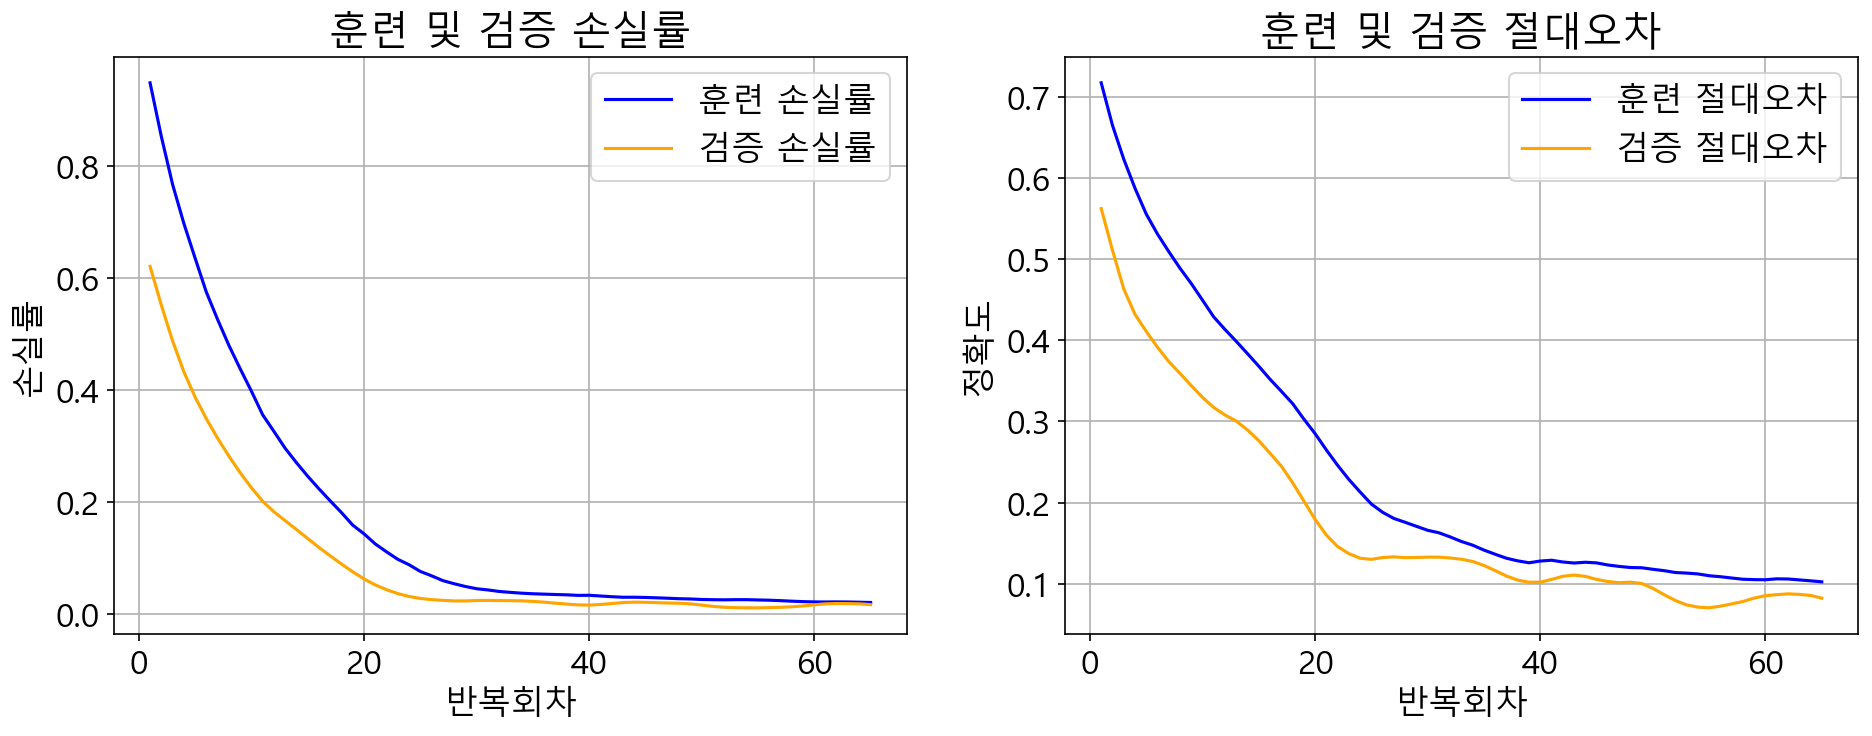

In [19]:
# ------------------------------
# 그래프 기본 설정
# ------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------
# 그래프를 그리기 위한 객체 생성
# ------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# ------------------------------
# 1) 훈련 및 검증 손실 그리기
# ------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# ------------------------------
# 2) 훈련 및 검증 절대오차 그리기
# ------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

### 손실률 숫자화

In [20]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률 : %f, 최종 훈련 절대오차 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률 : %f, 최종 검증 절대오차 : %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 10ms/step - loss: 0.0208 - mae: 0.1012
최종 훈련 손실률 : 0.020753, 최종 훈련 절대오차 : 0.101237
1/1 [==============================] - 0s 30ms/step - loss: 0.0174 - mae: 0.0825
최종 검증 손실률 : 0.017446, 최종 검증 절대오차 : 0.082455


## #08. 학습 결과 적용

### 예측 결과 산정

In [21]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 22ms/step


### 결과 데이터 셋 구성

In [22]:
origin.columns

Index(['길이', '높이', '두께', '무게'], dtype='object')

#### 훈련 데이터

In [23]:
train_df = DataFrame(x_train, columns=['길이', '높이', '두께'])
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.862814,-0.847796,-0.015017
1,-2.180225,-2.016507,-1.896175,-1.092422,-1.241146,0.148724
2,-0.659101,-0.779008,-0.696689,-0.761217,-0.720021,-0.041196
3,-0.368297,-0.396891,-0.327179,-0.563830,-0.565225,0.001395
4,1.577847,1.731046,1.207709,2.083485,1.689536,0.393949


#### 검증 데이터

In [24]:
test_df = DataFrame(x_test, columns=['길이','높이','두께'])
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.732189,-0.718675,-0.013514
1,-0.770948,-0.761480,-0.611417,-0.746703,-0.698115,-0.048589
2,-0.580807,-0.670333,-0.634156,-0.688648,-0.687226,-0.001422
3,-0.043940,-0.204080,-0.099788,-0.383859,-0.420591,0.036733
4,0.235678,-0.084887,0.013907,-0.180666,-0.163822,-0.016844


### 실제 결과값과 머신러닝에 의한 예측값 비교

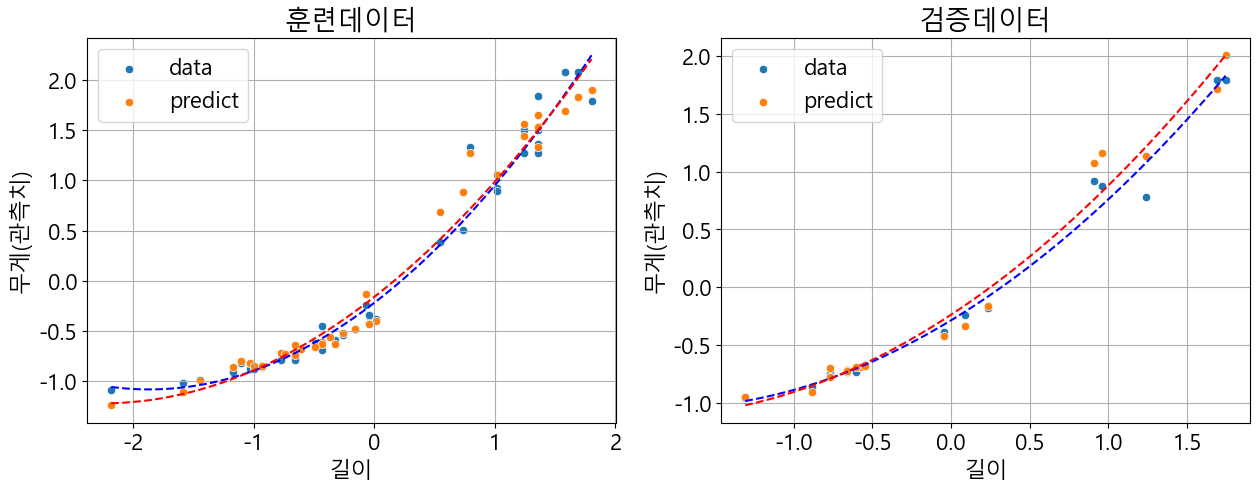

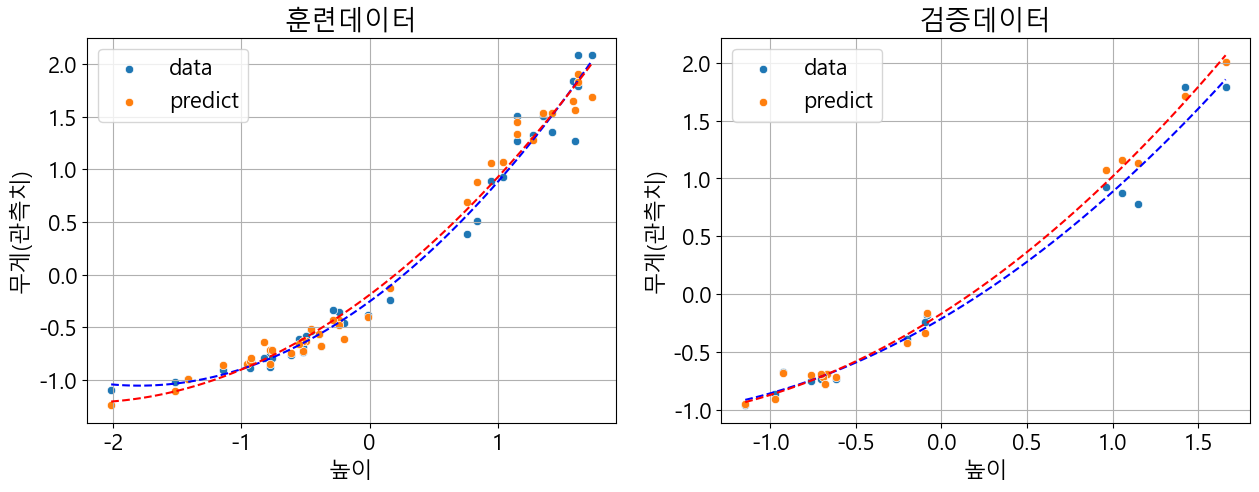

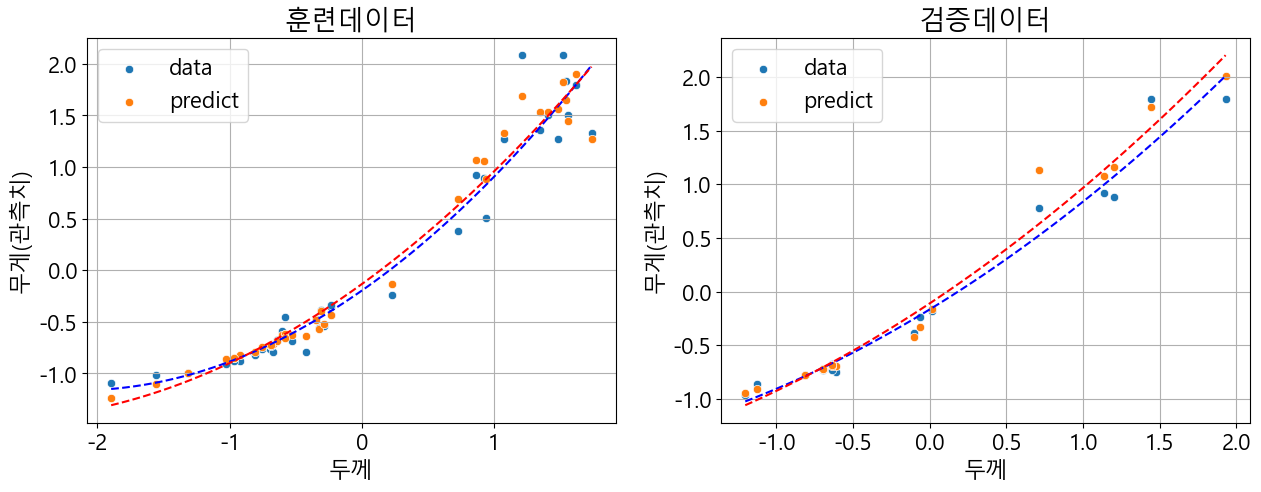

In [25]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))